<a href="https://colab.research.google.com/github/tasnimislamraisa/Python_Learning/blob/main/CLIP_%2B_Cross_Attention_%2B_LoRA_85_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install transformers peft accelerate torchvision scikit-learn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os, json, re, random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda


In [16]:
BASE_DIR = "/content/drive/MyDrive/FakeNews_Multimodal_Dataset/fakeddit_subset"

TRAIN_JSON = os.path.join(BASE_DIR, "training_data_fakeddit.jsonl")
VAL_JSON   = os.path.join(BASE_DIR, "validation_data_fakeddit.jsonl")

TRAIN_IMG_DIR = os.path.join(BASE_DIR, "image_folder")
VAL_IMG_DIR   = os.path.join(BASE_DIR, "validation_image")

print("TRAIN_JSON exists:", os.path.exists(TRAIN_JSON))
print("VAL_JSON exists:", os.path.exists(VAL_JSON))
print("TRAIN_IMG_DIR exists:", os.path.exists(TRAIN_IMG_DIR))
print("VAL_IMG_DIR exists:", os.path.exists(VAL_IMG_DIR))

if os.path.exists(TRAIN_IMG_DIR): print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
if os.path.exists(VAL_IMG_DIR):   print("Val images:", len(os.listdir(VAL_IMG_DIR)))

TRAIN_JSON exists: True
VAL_JSON exists: True
TRAIN_IMG_DIR exists: True
VAL_IMG_DIR exists: True
Train images: 4000
Val images: 4210


In [17]:
def load_jsonl(path):
    rows = []
    with open(path, "r") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

train_raw = load_jsonl(TRAIN_JSON)
val_raw   = load_jsonl(VAL_JSON)

def clean_text(t):
    m = re.search(r'Title:"(.*?)"', t, flags=re.IGNORECASE|re.DOTALL)
    return m.group(1).strip() if m else t.strip()

def parse_contents(df):
    records = []
    for row in df["contents"]:
        user_part  = row[0]
        model_part = row[1]

        image, text = None, None

        for part in user_part.get("parts", []):
            if "fileData" in part:
                image = part["fileData"]["fileUri"].split("/")[-1]
            if "text" in part:
                text = part["text"]

        label_text = model_part["parts"][0]["text"].strip().lower()
        label = 1 if label_text == "yes" else 0

        if image and text:
            records.append({"image": image, "text": clean_text(text), "label": label})

    return pd.DataFrame(records)

train_df = parse_contents(train_raw)
val_df   = parse_contents(val_raw)

In [18]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("\nTrain label counts:\n", train_df["label"].value_counts(normalize=True))
print("\nVal label counts:\n", val_df["label"].value_counts(normalize=True))

# show some samples
print("\nExample rows:")
print(train_df[["image","text","label"]].head(3))

Train size: 4000
Val size: 4210

Train label counts:
 label
0    0.57275
1    0.42725
Name: proportion, dtype: float64

Val label counts:
 label
0    0.557957
1    0.442043
Name: proportion, dtype: float64

Example rows:
                                  image  \
0  9a46c1362ec06f0ffbd2578fa777ea8d.jpg   
1  18bb4fa9fd1dfc1fd318887c997a01d5.jpg   
2  44ac90bced0683e03379f63adac4317a.jpg   

                                                text  label  
0  he cut some tomatoes and put them in a bucket ...      1  
1       crazy tennis face ripe for the photoshopping      0  
2                         spicy vitamin water exists      0  


In [19]:
def add_hard_negatives_soft(train_df, frac=0.10, seed=42):
    df = train_df.copy().reset_index(drop=True)
    n = int(len(df) * frac)

    rng = np.random.default_rng(seed)
    idx = rng.choice(len(df), size=n, replace=False)

    shuffled_images = df.loc[idx, "image"].sample(frac=1.0, random_state=seed).values

    df_aug = df.loc[idx].copy()
    df_aug["image"] = shuffled_images

    out = pd.concat([df, df_aug], ignore_index=True)
    out = out.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    print(f"Soft hard negatives: {len(df)} -> {len(out)}")
    return out

train_df = add_hard_negatives_soft(train_df, frac=0.10)

Soft hard negatives: 4000 -> 4400


In [20]:
labels_np = train_df["label"].values
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.array([0,1]),
                                     y=labels_np)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

print("Class weights [Real, Fake]:", class_weights.tolist())



Class weights [Real, Fake]: [0.8785942196846008, 1.1603375673294067]


In [21]:

processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

class FakedditCLIPDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image"])

        image = Image.open(img_path).convert("RGB")
        text  = row["text"]
        label = int(row["label"])

        enc = processor(text=[text],
                        images=[image],
                        return_tensors="pt",
                        padding="max_length",
                        truncation=True,
                        max_length=64)

        return {
            "pixel_values": enc["pixel_values"].squeeze(0),
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label)
        }

train_loader = DataLoader(FakedditCLIPDataset(train_df, TRAIN_IMG_DIR),
                          batch_size=8, shuffle=True)

val_loader = DataLoader(FakedditCLIPDataset(val_df, VAL_IMG_DIR),
                        batch_size=8, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [22]:


clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","out_proj"]
)

clip = get_peft_model(clip, lora_config)

for name, p in clip.named_parameters():
    if "lora_" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

class CLIPCrossAttention(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model

        d = 512
       # self.txt_proj = nn.Linear(512, d)
        #self.vis_proj = nn.Linear(768, d)

        self.txt_proj = nn.Linear(768, d)   # CLIP-L text dim
        self.vis_proj = nn.Linear(1024, d)  # CLIP-L vision dim

        self.cross_attn = nn.MultiheadAttention(d, 8, batch_first=True)


        self.classifier = nn.Sequential(
            nn.Linear(d*2, d),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(d, 2)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        text_out = self.clip.text_model(input_ids=input_ids,
                                        attention_mask=attention_mask,
                                        return_dict=True)

        vision_out = self.clip.vision_model(pixel_values=pixel_values,
                                            return_dict=True)

        txt_tokens = self.txt_proj(text_out.last_hidden_state)
        img_tokens = self.vis_proj(vision_out.last_hidden_state)

        fused_txt, _ = self.cross_attn(txt_tokens, img_tokens, img_tokens)
        fused_img, _ = self.cross_attn(img_tokens, txt_tokens, txt_tokens)

        txt_vec = fused_txt[:,0,:]
        img_vec = fused_img[:,0,:]

        out = torch.cat([txt_vec, img_vec], dim=1)
        return self.classifier(out)

model = CLIPCrossAttention(clip).to(DEVICE)

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
text_model.embeddings.position_ids   | UNEXPECTED |  | 
vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [23]:
def set_crossattn_trainable(model, trainable):
    for p in model.cross_attn.parameters():
        p.requires_grad = trainable

# Freeze cross-attention for first epoch
set_crossattn_trainable(model, False)

In [24]:
#criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)

from transformers import get_cosine_schedule_with_warmup

EPOCHS = 10
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,              # lower LR helps stability
    weight_decay=0.05     # stronger regularization
)

total_steps = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
scheduler.step()

/tmp/ipython-input-979538086.py:24: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()


In [25]:
optimizer.step()

In [26]:
scheduler.step()

In [27]:
EPOCHS = 10
best_acc = 0

for epoch in range(EPOCHS):

    # 🔹 Unfreeze cross-attention at epoch 2
    if epoch == 1:
        print("Unfreezing cross-attention...")
        set_crossattn_trainable(model, True)

        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=5e-5,
            weight_decay=0.05
        )

    model.train()
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(pixel_values, input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()   # 🔹 important if using cosine scheduler

        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    # 🔹 Validation
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            logits = model(pixel_values, input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)[:, 1]

            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = correct / total

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("Train Acc:", train_acc)
    print("Val Acc:", val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved best model")

print("Best Val Acc:", best_acc)

100%|██████████| 550/550 [36:42<00:00,  4.01s/it]



Epoch 1/10
Train Acc: 0.6772727272727272
Val Acc: 0.8230403800475059
Saved best model
Unfreezing cross-attention...


100%|██████████| 550/550 [10:22<00:00,  1.13s/it]



Epoch 2/10
Train Acc: 0.8697727272727273
Val Acc: 0.8429928741092637
Saved best model


100%|██████████| 550/550 [10:22<00:00,  1.13s/it]



Epoch 3/10
Train Acc: 0.9522727272727273
Val Acc: 0.8510688836104513
Saved best model


100%|██████████| 550/550 [10:23<00:00,  1.13s/it]



Epoch 4/10
Train Acc: 0.990909090909091
Val Acc: 0.8465558194774346


100%|██████████| 550/550 [10:24<00:00,  1.13s/it]



Epoch 5/10
Train Acc: 0.9988636363636364
Val Acc: 0.8446555819477435


100%|██████████| 550/550 [10:24<00:00,  1.14s/it]



Epoch 6/10
Train Acc: 0.9995454545454545
Val Acc: 0.8508313539192399


100%|██████████| 550/550 [10:23<00:00,  1.13s/it]



Epoch 7/10
Train Acc: 0.9997727272727273
Val Acc: 0.8484560570071259


100%|██████████| 550/550 [10:21<00:00,  1.13s/it]



Epoch 8/10
Train Acc: 0.9993181818181818
Val Acc: 0.8494061757719715


100%|██████████| 550/550 [10:28<00:00,  1.14s/it]



Epoch 9/10
Train Acc: 0.9997727272727273
Val Acc: 0.8441805225653206


100%|██████████| 550/550 [10:24<00:00,  1.13s/it]



Epoch 10/10
Train Acc: 0.9956818181818182
Val Acc: 0.8391923990498812
Best Val Acc: 0.8510688836104513


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import torch

EPOCHS = 10
best_acc = 0.0

# store curves
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(EPOCHS):

    # 🔹 Unfreeze cross-attention at epoch 2 (index=1)
    if epoch == 1:
        print("Unfreezing cross-attention...")
        set_crossattn_trainable(model, True)

        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=5e-5,
            weight_decay=0.05
        )

        # rebuild scheduler correctly after optimizer reset
        total_steps = len(train_loader) * EPOCHS
        warmup_steps = int(0.1 * total_steps)
        from transformers import get_cosine_schedule_with_warmup
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    # ======================
    # TRAIN
    # ======================
    model.train()
    correct = 0
    total = 0
    train_loss_sum = 0.0

    for batch in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad(set_to_none=True)

        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(pixel_values, input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss_sum += loss.item()
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = train_loss_sum / len(train_loader)

    # ======================
    # VALIDATION
    # ======================
    model.eval()
    correct = 0
    total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val {epoch+1}/{EPOCHS}"):
            pixel_values = batch["pixel_values"].to(DEVICE)
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            logits = model(pixel_values, input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss_sum += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = val_loss_sum / len(val_loader)

    # save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Saved best model.")

print("Best Val Acc:", best_acc)

In [ ]:
import matplotlib.pyplot as plt

# Extracted from your log (Epoch 1 to 8)
epochs = [1,2,3,4,5,6,7,8]

train_acc = [
    0.6772727272727272,
    0.8697727272727273,
    0.9522727272727273,
    0.990909090909091,
    0.9988636363636364,
    0.9995454545454545,
    0.9997727272727273,
    0.9993181818181818
]

val_acc = [
    0.8230403800475059,
    0.8429928741092637,
    0.8510688836104513,
    0.8465558194774346,
    0.8446555819477435,
    0.8508313539192399,
    0.8484560570071259,
    0.8494061757719715
]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, marker="o", label="Training Accuracy")
plt.plot(epochs, val_acc, marker="o", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xticks(epochs)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Final Evaluation: 100%|██████████| 527/527 [04:57<00:00,  1.77it/s]


Best Threshold: 0.44000000000000006
Best F1: 0.8310919849381387

===== BEST THRESHOLD REPORT =====
              precision    recall  f1-score   support

           0     0.8657    0.8672    0.8664      2349
           1     0.8320    0.8302    0.8311      1861

    accuracy                         0.8508      4210
   macro avg     0.8488    0.8487    0.8488      4210
weighted avg     0.8508    0.8508    0.8508      4210



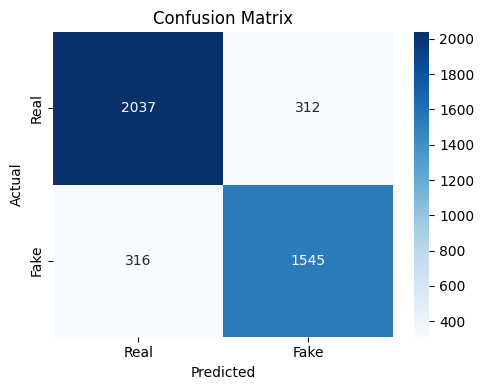

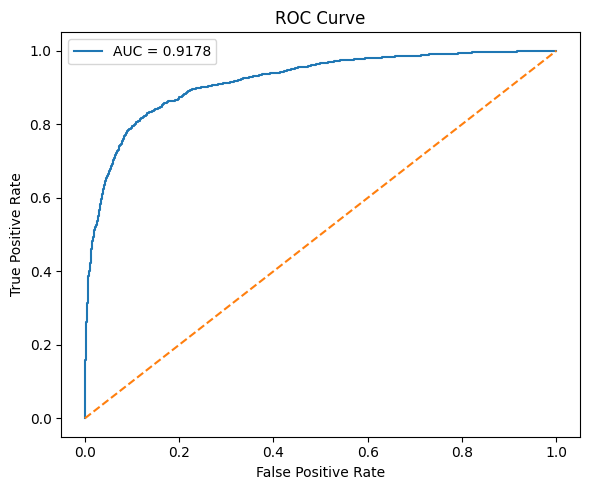

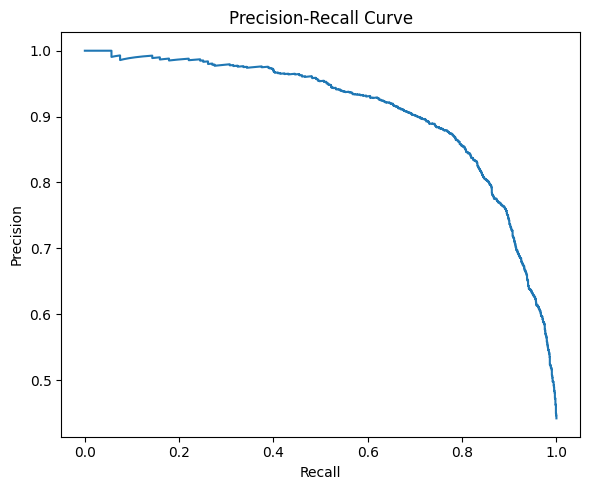


Final ROC-AUC: 0.9177513657245849


NameError: name 'history' is not defined

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score
)

# ==============================
# 1) Load best model & collect probs
# ==============================
model.load_state_dict(torch.load("best_model.pt", map_location=DEVICE))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Evaluation"):
        pixel_values = batch["pixel_values"].to(DEVICE)
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        logits = model(pixel_values, input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1]

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# ==============================
# 2) Threshold vs F1 curve + best threshold
# ==============================
thresholds = np.arange(0.05, 0.96, 0.01)
f1s = []

for t in thresholds:
    preds_t = (all_probs >= t).astype(int)
    f1s.append(f1_score(all_labels, preds_t))

f1s = np.array(f1s)
best_idx = int(np.argmax(f1s))
best_thresh = float(thresholds[best_idx])
best_f1 = float(f1s[best_idx])

print("Best Threshold:", best_thresh)
print("Best F1:", best_f1)

preds_best = (all_probs >= best_thresh).astype(int)

print("\n===== BEST THRESHOLD REPORT =====")
print(classification_report(all_labels, preds_best, digits=4))

# ==============================
# 3) Confusion Matrix
# ==============================
cm = confusion_matrix(all_labels, preds_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ==============================
# 4) ROC Curve + AUC
# ==============================
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 5) Precision-Recall Curve
# ==============================
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

print("\nFinal ROC-AUC:", roc_auc)

# ==============================
# 6) Training vs Validation Accuracy curve
# ==============================
epochs = np.arange(1, len(history["train_acc"]) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 7) Training vs Validation Loss curve
# ==============================
plt.figure(figsize=(7,5))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# 8) Threshold vs F1 curve (strong addition)
# ==============================
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1s)
plt.axvline(best_thresh, linestyle="--", label=f"Best t={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score (Fake class)")
plt.title("Threshold vs F1-score")
plt.legend()
plt.tight_layout()
plt.show()